# Exploratory Data Analysis

The goal is to predict SalePrice

In [1]:
KAGGLE=False # set to True if using the Kaggle version of the dataset

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


import catboost as cb

from xgboost import XGBRegressor


In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

The data has been pre-processed

In [4]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocs.csv', index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

If working with the Kaggle version of the dataset, can use the function below to do train-test split

In [19]:
#cats = [f for f in alldata.columns if alldata.dtypes[f] == 'object']

In [6]:
#cat_idxs=[]

In [5]:
def label_encode():
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in alldata.columns:
        if alldata[column_name].dtype == object:
            #cat_idxs.append(alldata.columns.get_loc(column_name))
            #alldata[column_name] = alldata[column_name].astype(str)
            alldata[column_name] = le.fit_transform(alldata[column_name])
label_encode()

In [6]:
def split_into_train_test(alldata):
    y=alldata['SalePrice']
    X=alldata.drop(['SalePrice'],axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = split_into_train_test(alldata)  

The sale price appears to be skewed to the right

# Catboost

In [7]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)


#It would have been desirable to let CatBoost choose how to encode the catecorical columns
#Due to TypeError: Cannot convert 'b'RM'' to float
#I chose to LabelEncode beforehand

# train_dataset = cb.Pool(X_train, y_train,cat_features=cat_idxs) 
# test_dataset = cb.Pool(X_test, y_test,cat_features=cat_idxs)

In [9]:
model_cb = cb.CatBoostRegressor(loss_function='RMSE',verbose=False)

In [10]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb.grid_search(grid, train_dataset,verbose=False)


bestTest = 35724.70836
bestIteration = 99


bestTest = 23477.76152
bestIteration = 99


bestTest = 35624.79944
bestIteration = 99


bestTest = 23838.54742
bestIteration = 99


bestTest = 35786.15839
bestIteration = 99


bestTest = 24365.19556
bestIteration = 99


bestTest = 36204.41094
bestIteration = 99


bestTest = 24902.48155
bestIteration = 99


bestTest = 29007.70374
bestIteration = 149


bestTest = 22055.50884
bestIteration = 149


bestTest = 29028.02651
bestIteration = 149


bestTest = 22297.03043
bestIteration = 149


bestTest = 29175.55738
bestIteration = 149


bestTest = 22966.42029
bestIteration = 149


bestTest = 29513.44759
bestIteration = 149


bestTest = 23679.07493
bestIteration = 149


bestTest = 26509.00341
bestIteration = 199


bestTest = 21249.80302
bestIteration = 197


bestTest = 26509.49392
bestIteration = 199


bestTest = 21554.62419
bestIteration = 199


bestTest = 26563.40099
bestIteration = 199


bestTest = 21955.89152
bestIteration = 199


bestTest = 26982.

{'params': {'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [11]:
from sklearn.metrics import r2_score

pred = model_cb.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

#With lats/longs data, R2 went up from .93 to .95!!!

Testing performance
RMSE: 18476.49
R2: 0.95


In [39]:
sorted_feature_importance = model_cb.feature_importances_.argsort()

In [40]:
#sorted_feature_importance = np.argsort(model_cb.feature_importances_)[:20]

In [41]:
# top20=sorted_feature_importance [:20]

# plt.rcParams["figure.figsize"] = (15, 15)

# plt.barh(alldata.columns[top20], 
#         model_cb.feature_importances_[top20], 
#         color='turquoise')
# plt.xlabel("CatBoost Feature Importance")

Text(0.5, 0, 'CatBoost Feature Importance')

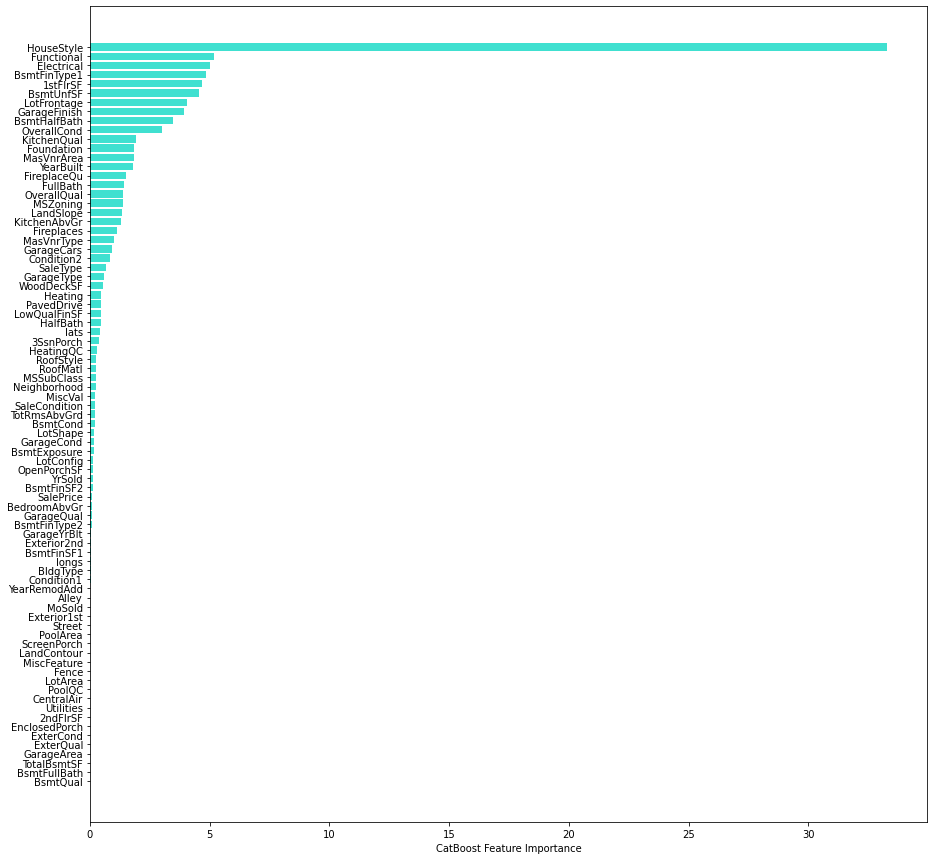

In [43]:
plt.rcParams["figure.figsize"] = (15, 15)

plt.barh(alldata.columns[sorted_feature_importance], 
        model_cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [68]:
importances = {}
importances['y'] = pd.Series(model_cb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      33.292307
Fireplaces        5.193743
1stFlrSF          5.019614
BsmtFinSF1        4.861471
2ndFlrSF          4.671689
TotalBsmtSF       4.570124
LotArea           4.070996
GarageCars        3.943279
FullBath          3.489306
YearBuilt         2.993169
TotRmsAbvGrd      1.943535
BsmtQual          1.849760
ExterQual         1.835349
YearRemodAdd      1.817312
GarageType        1.502574
HalfBath          1.424753
OverallCond       1.393693
LotFrontage       1.366963
Neighborhood      1.319274
KitchenQual       1.276344
FireplaceQu       1.130781
MasVnrArea        1.010055
GarageArea        0.937050
BldgType          0.837680
SaleCondition     0.678711
GarageYrBlt       0.582699
OpenPorchSF       0.553384
HeatingQC         0.475455
WoodDeckSF        0.473752
BsmtFullBath      0.446145
BedroomAbvGr      0.442441
longs             0.430685
ScreenPorch       0.381385
CentralAir        0.306564
RoofMatl          0.252953
Exterior1st       0.247618
MSZoning          0.243502
C

In [44]:
import shap

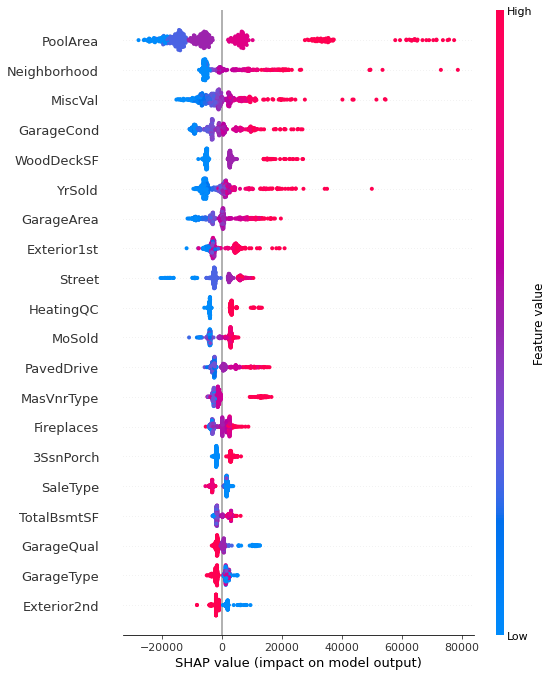

In [96]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

In [99]:
#shap.plots.waterfall??

In [102]:
# explainer = shap.Explainer(model_cb, X_test)
# shap_values = explainer(X_test)
# shap.plots.waterfall(shap_values[0])

In [46]:
import pickle
pickle.dump(model_cb, open('model_cb_locs', 'wb'))

#loaded_cb = pickle.load(open('model_cb', 'rb'))

# RF

In [106]:
class TrainTree:
    def __init__(self,X_train, X_test, y_train, y_test,model,grid):
        self.model=model
        self.grid=grid
        self.X_train, self.X_test, self.y_train, self.y_test=X_train, X_test, y_train, y_test
 
    def run_tree(self):    
        cv=KFold(n_splits=5, random_state=42, shuffle=True)
        gsCV = GridSearchCV(cv=cv,
                     estimator=self.model,
                     n_jobs=2,
                     param_grid=self.grid,
                     return_train_score=True,
                     verbose=4)

        %time obj = gsCV.fit(self.X_train, self.y_train)

        preds = gsCV.predict(self.X_test)
        kf = KFold(n_splits=12, random_state=42, shuffle=True)
        rmse_cv = np.sqrt(-cross_val_score(self.model, self.X_train, self.y_train, scoring="neg_mean_squared_error", cv=cv))

        rmse = np.sqrt(mean_squared_error(self.y_test,preds))
        print(f'RMSE on Test: {rmse}')
        print(f'RMSE from CV: {rmse_cv.mean()}')
        return gsCV

In [108]:
#TRAINED AFTER MODIFYING CLASS
# grid_rf={'n_estimators':range(100,200,100), 'min_samples_leaf':range(10,20,10)}



# rf_=TrainTree(X_train, X_test, y_train, y_test,
#             RandomForestRegressor(random_state=42, verbose=1),
#             grid = grid_rf)
# results=rf_.run_tree()

In [109]:
# grid_rf={'n_estimators':range(700,1200,100)}

# rf_=TrainTree(alldata,
#             RandomForestRegressor(random_state=42, verbose=1,min_samples_leaf=10,max_depth=15),
#             grid = grid_rf)
# model_rf=rf_.run_tree()


In [110]:
# model_rf=results
# from sklearn.metrics import r2_score

# pred = model_rf.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))
# print('R2: {:.2f}'.format(r2))

In [111]:
#Pre-Coords
#model_rf=results
# from sklearn.metrics import r2_score

# pred = model_rf.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))
# print('R2: {:.2f}'.format(r2))

In [89]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 24901.07738728411
R^2 : 0.9042752985380887


RandomForestRegressor()

In [90]:
pickle.dump(model_rf, open('model_rf_locs', 'wb'))


In [66]:
importances = {}
importances['y'] = pd.Series(model_rf.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      0.635982
1stFlrSF         0.070453
GarageArea       0.050562
FullBath         0.048541
TotalBsmtSF      0.030374
2ndFlrSF         0.027804
BsmtFinSF1       0.020247
LotArea          0.019979
GarageCars       0.011141
BsmtQual         0.008913
Fireplaces       0.008024
GarageType       0.005376
YearRemodAdd     0.005127
LotFrontage      0.004572
KitchenQual      0.004295
MasVnrArea       0.004269
lats             0.004208
TotRmsAbvGrd     0.004097
YearBuilt        0.002953
longs            0.002914
Neighborhood     0.002556
WoodDeckSF       0.002526
BsmtUnfSF        0.002101
BedroomAbvGr     0.002007
OpenPorchSF      0.001803
CentralAir       0.001702
BsmtFullBath     0.001607
ExterQual        0.001516
GarageYrBlt      0.001408
OverallCond      0.001288
HalfBath         0.001281
FireplaceQu      0.001179
BsmtFinType1     0.001108
MSSubClass       0.000854
MSZoning         0.000702
GarageFinish     0.000642
MoSold           0.000614
HeatingQC        0.000532
Exterior1st 

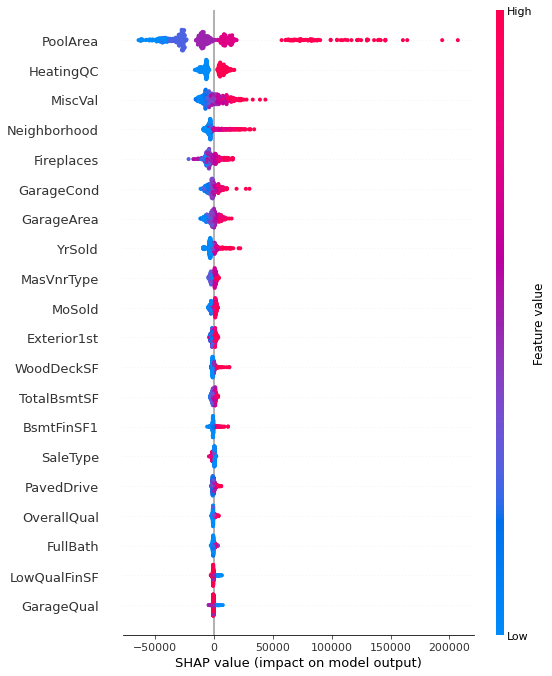

In [92]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

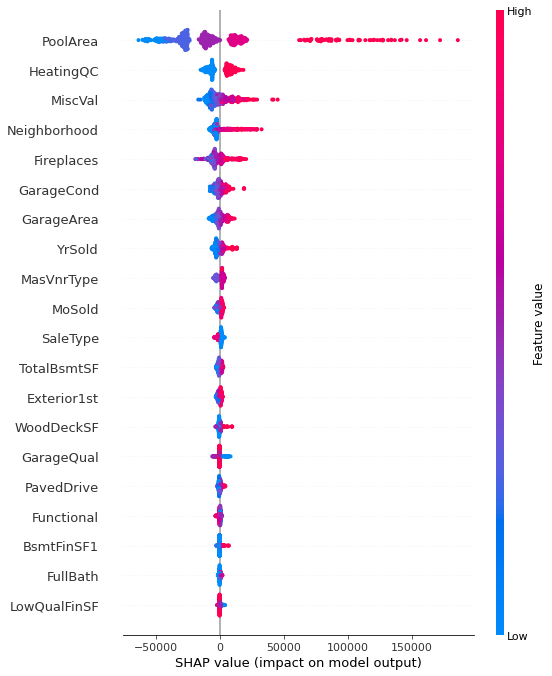

In [71]:
explainer = shap.TreeExplainer(model_rf.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

# XGBoost

In [56]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':range(4000,8000,1000), 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                       reg_alpha=0.00006,
                       random_state=42)
xgb_=TrainTree(alldata,
           model=xgboost,
            grid = grid_xgb)
model_xgb=xgb_.run_tree()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[16:02:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 38s, sys: 1.84 s, total: 1min 40s
Wall time: 19min 38s
[16:02:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:02:43] WARNING: /Users/runn

In [22]:
results_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.6, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=0,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=42, ...)

In [57]:
from sklearn.metrics import r2_score

pred = model_xgb.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 19219.45
R2: 0.94


In [42]:
from sklearn.metrics import r2_score

pred = model_xgb.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 20217.38
R2: 0.93


In [60]:
pickle.dump(model_xgb, open('model_xgb_locs', 'wb'))

#loaded_xgb = pickle.load(open('model_xgb', 'rb'))

In [94]:
importances = {}
importances['y'] = pd.Series(model_xgb.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

GarageCars       0.254405
OverallQual      0.215833
FullBath         0.081226
ExterQual        0.072797
KitchenQual      0.045290
BsmtQual         0.040388
Fireplaces       0.031338
1stFlrSF         0.016111
2ndFlrSF         0.015043
YearBuilt        0.013794
CentralAir       0.013709
HalfBath         0.013460
TotalBsmtSF      0.013280
GarageType       0.013091
TotRmsAbvGrd     0.010750
BsmtFinSF1       0.010152
GarageArea       0.009849
FireplaceQu      0.007514
RoofMatl         0.006881
BsmtFullBath     0.006794
YearRemodAdd     0.006363
MissingLoc       0.005454
OverallCond      0.005124
LotArea          0.005060
SaleCondition    0.004414
LandContour      0.004363
PavedDrive       0.004264
MSZoning         0.003770
Street           0.003620
GarageFinish     0.003285
ScreenPorch      0.002918
BsmtFinType1     0.002807
Neighborhood     0.002603
BedroomAbvGr     0.002400
BsmtExposure     0.002371
Functional       0.002327
Condition2       0.002310
Condition1       0.002064
Utilities   

In [19]:
rf.set_params(random_state=42)
results = {}
%time obj = gsCV.fit(X_train, y_train)  # fit the random forest grid search CV on different targets
#results[key] = obj.cv_results_

CPU times: user 984 ms, sys: 181 ms, total: 1.17 s
Wall time: 18.9 s


In [22]:
#rf.set_params(max_depth=7, n_estimators=90, random_state=42)
rf=rf.fit(X_train, y_train)

In [79]:
#rf.set_params(max_depth=7, n_estimators=90, random_state=42) Importances
importances = {}
importances['y'] = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
#importances['y']

NameError: name 'rf' is not defined

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


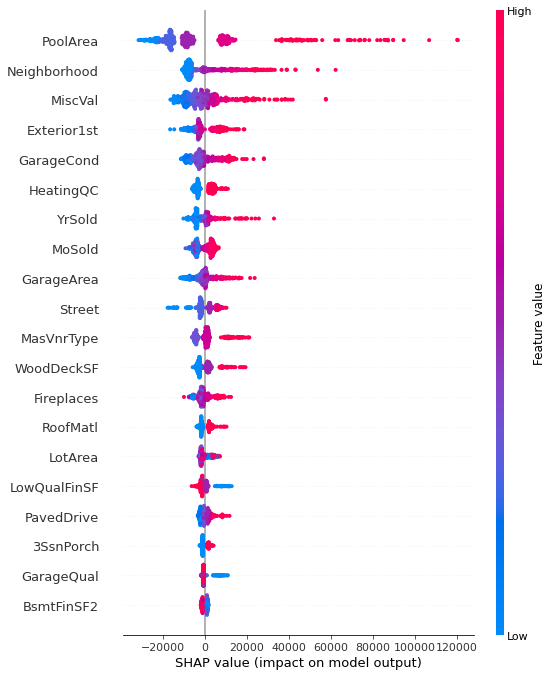

In [72]:
explainer = shap.TreeExplainer(model_xgb.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

In [25]:
gsCV.cv_results_

{'mean_fit_time': array([0.13731003, 0.20241771, 0.28994455, 0.11840916, 0.22185397,
        0.36102505, 0.13070731, 0.35785809, 0.369169  , 0.14255509,
        0.27100358, 0.42316341, 0.19262953, 0.34252191, 0.49759007,
        0.1827415 , 0.33580637, 0.53333473, 0.2174531 , 0.43827133,
        0.62053156, 0.21581898, 0.43469987, 0.56841054, 0.19304004,
        0.38592954, 0.56893582]),
 'std_fit_time': array([0.0164978 , 0.00789645, 0.01282453, 0.00868703, 0.00811302,
        0.07031573, 0.01051655, 0.09044486, 0.00706384, 0.00627622,
        0.00330567, 0.03910249, 0.03903643, 0.01674175, 0.01164095,
        0.01090683, 0.00443953, 0.02634139, 0.03364108, 0.04130907,
        0.07567067, 0.05353143, 0.0384863 , 0.03084288, 0.00256376,
        0.00974226, 0.03936993]),
 'mean_score_time': array([0.01215134, 0.01686325, 0.02400575, 0.01168423, 0.01871219,
        0.02510338, 0.01258864, 0.01831489, 0.02694964, 0.01243196,
        0.01943259, 0.02981615, 0.01804662, 0.02095203, 0.032892

In [ ]:
## Another approach

In [16]:
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42,
                          verbose=1)
scores = {}

In [17]:
#rf.set_params(max_depth=7, n_estimators=90, random_state=42)
model_rf=rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   25.4s finished


In [18]:
#model_rf??

In [19]:
model_rf.oob_prediction_

array([239457.71841892, 120504.60246552,  93639.24290159, ...,
       169683.43944836, 113164.23286785, 184926.83339289])

In [20]:
#rf.set_params(max_depth=7, n_estimators=90, random_state=42) Importances
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

NameError: name 'model_rf' is not defined

In [35]:
# rf = RandomForestRegressor(n_estimators=1200,
#                           max_depth=15,
#                           min_samples_split=5,
#                           min_samples_leaf=5,
#                           max_features=None,
#                           oob_score=True,
#                           random_state=42,
#                           verbose=1)
#Importances
importances = {}
importances['y'] = pd.Series(f.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      6.187084e-01
GrLivArea        1.145109e-01
TotalBsmtSF      4.401227e-02
BsmtFinSF1       2.886036e-02
1stFlrSF         2.249027e-02
GarageCars       2.158788e-02
GarageArea       1.474673e-02
LotArea          1.135069e-02
2ndFlrSF         1.028816e-02
FullBath         8.421148e-03
YearBuilt        7.938778e-03
TotRmsAbvGrd     7.182271e-03
Neighborhood     6.433346e-03
YearRemodAdd     6.048100e-03
GarageType       5.309292e-03
LotFrontage      4.760660e-03
GarageFinish     4.507426e-03
BsmtQual         4.280382e-03
MasVnrArea       3.965928e-03
WoodDeckSF       3.738678e-03
BsmtUnfSF        3.657392e-03
OpenPorchSF      3.631555e-03
BedroomAbvGr     3.544082e-03
ExterQual        3.529301e-03
OverallCond      3.293003e-03
GarageYrBlt      3.115182e-03
CentralAir       2.986390e-03
KitchenQual      2.314719e-03
Fireplaces       2.097281e-03
MoSold           1.999886e-03
BsmtExposure     1.755994e-03
LotShape         1.610955e-03
FireplaceQu      1.576694e-03
BsmtFinTyp

In [21]:
rf_preds = model_rf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.4s finished


# Compare a few different models below to get an idea of relative performance

In [23]:
np.sqrt(mean_squared_error(y_test,rf_preds))

26638.187671921078

In [73]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE : {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 : {r2}')

    return model

In [74]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE : 25385.31006861012
R^2 : 0.9005161258306823


LinearRegression()

In [75]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 25144.762988612016
R^2 : 0.9023925791293337


RandomForestRegressor()

In [78]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      5.815197e-01
1stFlrSF         5.826681e-02
FullBath         4.307005e-02
GarageArea       3.900812e-02
2ndFlrSF         3.135091e-02
TotalBsmtSF      3.122583e-02
BsmtFinSF1       2.986800e-02
LotArea          2.209708e-02
GarageCars       1.344276e-02
Fireplaces       1.027501e-02
lats             9.364675e-03
MasVnrArea       7.342814e-03
LotFrontage      7.166977e-03
KitchenQual      6.982249e-03
TotRmsAbvGrd     6.667535e-03
BsmtQual         6.324967e-03
YearBuilt        6.177922e-03
YearRemodAdd     6.138475e-03
longs            5.294645e-03
Neighborhood     5.201677e-03
WoodDeckSF       5.169345e-03
OpenPorchSF      4.986943e-03
BsmtUnfSF        4.616367e-03
MoSold           4.047977e-03
OverallCond      3.496752e-03
GarageYrBlt      3.405651e-03
GarageType       2.976310e-03
FireplaceQu      2.478084e-03
ExterQual        2.418700e-03
BedroomAbvGr     2.349930e-03
MSSubClass       2.022964e-03
BsmtFullBath     1.953859e-03
BsmtFinType1     1.784642e-03
Exterior1s

In [76]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

model_gb = GradientBoostingRegressor()
run_model(model_gb,X_train,y_train,X_test,y_test)

RMSE : 21649.56045272719
R^2 : 0.9276421071228171


GradientBoostingRegressor()

In [77]:
from sklearn.ensemble import AdaBoostRegressor
model_ab = AdaBoostRegressor()
run_model(model_ab,X_train,y_train,X_test,y_test)

RMSE : 34856.118423080276
R^2 : 0.8124375964332984


AdaBoostRegressor()

In [42]:
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}  #Are gammas for variance?
svr = SVR()
grid = GridSearchCV(svr,param_grid)
run_model(grid,X_train,y_train,X_test,y_test)



RMSE : 80957.62904185217


In [41]:
# from sklearn.preprocessing import RobustScaler
# from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}  #Are gammas for variance?
# #svr = SVR()
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# grid = GridSearchCV(svr,param_grid)
# run_model(grid,X_train,y_train,X_test,y_test)



ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('robustscaler', RobustScaler()),
                ('svr', SVR(C=20, epsilon=0.008, gamma=0.0003))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

std_scale = StandardScaler()
s = std_scale.fit_transform(X_train)
pca = PCA(n_components=30)

pca.fit(X_train)
pc = pca.transform(s)
model_kmeans = KMeans(n_clusters=5)

run_model(model_kmeans,X_train,y_train,X_test,y_test)


RMSE : 199030.80108212752


/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [35]:
from sklearn.neighbors import KNeighborsRegressor
k_values = [1,5,10,50]

for n in k_values:
    model = KNeighborsRegressor(n_neighbors=n)
    run_model(model,X_train,y_train,X_test,y_test)

RMSE : 45896.06127854242
RMSE : 44574.96970627604
RMSE : 48929.23713010485
RMSE : 57164.68533098934


In [29]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
pipe = make_pipeline(OneHotEncoder(),StandardScaler(),PolynomialFeatures(3),LinearRegression())
run_model(pipe,X_train,y_train,X_test,y_test)

NameError: name 'mean_squared_error' is not defined